Just poking around seeing if we can get Bambi regressions working

## Housekeeping

Check working directory, set to project root

In [1]:
import os
print(os.getcwd())

c:\Users\cdonov12\local\repos\sm-docs\temp


In [2]:
# set it to parent directory if it is not project root
if os.path.basename(os.getcwd()) != 'sm-docs':
    os.chdir('..')
os.getcwd()

'c:\\Users\\cdonov12\\local\\repos\\sm-docs'

In [3]:
import numpy as np
import pandas as pd
import pyreadr
import bambi as bmb

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Load SM data used in regressions that includes covariates

In [4]:
#| output: false
dat = pyreadr.read_r('data/metrics_df_with_vals_and_covars.rds')
# dat = pyreadr.read_r('data/metrics_df.rds')
dat = dat[None]
dat = pd.DataFrame(dat)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 50 non-null     object 
 1   economics             50 non-null     float64
 2   environment           50 non-null     float64
 3   health                50 non-null     float64
 4   production            50 non-null     float64
 5   social                50 non-null     float64
 6   population            50 non-null     float64
 7   foodEnvironmentIndex  50 non-null     float64
 8   lifeExpectancy        50 non-null     float64
 9   foodInsecurity        50 non-null     float64
 10  happinessScore        50 non-null     float64
 11  wellbeingRank         50 non-null     float64
 12  communityEnvRank      50 non-null     float64
 13  workEnvRank           50 non-null     float64
 14  gdpCurrent            50 non-null     float64
 15  gdp_per_cap           50 

In [5]:
dat.head()

,state,economics,environment,health,production,social,population,foodEnvironmentIndex,lifeExpectancy,foodInsecurity,happinessScore,wellbeingRank,communityEnvRank,workEnvRank,gdpCurrent,gdp_per_cap
0,AL,0.185971,0.360635,0.288410,0.279973,0.392963,5074296.0,5.4,73.707861,0.148,39.32,45.0,46.0,40.0,304935.6,60.094169
1,AK,0.299390,0.370337,0.407871,0.270152,0.491739,733583.0,7.0,77.062679,0.107,46.27,24.0,49.0,37.0,68056.0,92.772052
2,AZ,0.183366,0.217690,0.329133,0.188366,0.480923,7359197.0,6.9,77.494877,0.103,50.22,28.0,33.0,29.0,522767.2,71.035902
3,AR,0.206933,0.389774,0.245531,0.223379,0.171020,3045637.0,4.7,74.301374,0.155,38.23,47.0,31.0,46.0,178606.4,58.643364
4,CA,0.314782,0.473866,0.507218,0.698518,0.445068,39029342.0,8.6,79.929738,0.105,59.97,12.0,5.0,14.0,3870378.9,99.165876


In [6]:
# Show column names that contain 'insecurity'
mask = dat.columns.str.contains('Insecurity')
dat.columns[mask]

Index(['foodInsecurity'], dtype='object')

## Sleep Study Example

In [7]:
import arviz as az
import bambi as bnb

In [8]:
data = bmb.load_data("sleepstudy")
data.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


In [9]:
model = bmb.Model('Reaction ~ Days', data)
print(model)

       Formula: Reaction ~ Days
        Family: gaussian
          Link: mu = identity
  Observations: 180
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 298.50789166666664, sigma: 261.00924843334496)
            Days ~ Normal(mu: 0.0, sigma: 48.89151175485448)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 56.172070431942394)


In [10]:
# Fit the model using 100 on each chain, just to make things go faster for testing
results = model.fit(draws=100, tune=100)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
# Key summary and diagnostic info on the model parameters
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,251.336,6.185,240.679,264.429,0.497,0.347,158.0,173.0,1.02
Days,10.421,1.134,8.661,13.092,0.078,0.069,216.0,190.0,1.01
Reaction_sigma,48.003,2.434,43.972,52.525,0.110,0.107,489.0,316.0,1.00


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Days'}>,
        <Axes: title={'center': 'Days'}>],
       [<Axes: title={'center': 'Reaction_sigma'}>,
        <Axes: title={'center': 'Reaction_sigma'}>]], dtype=object)

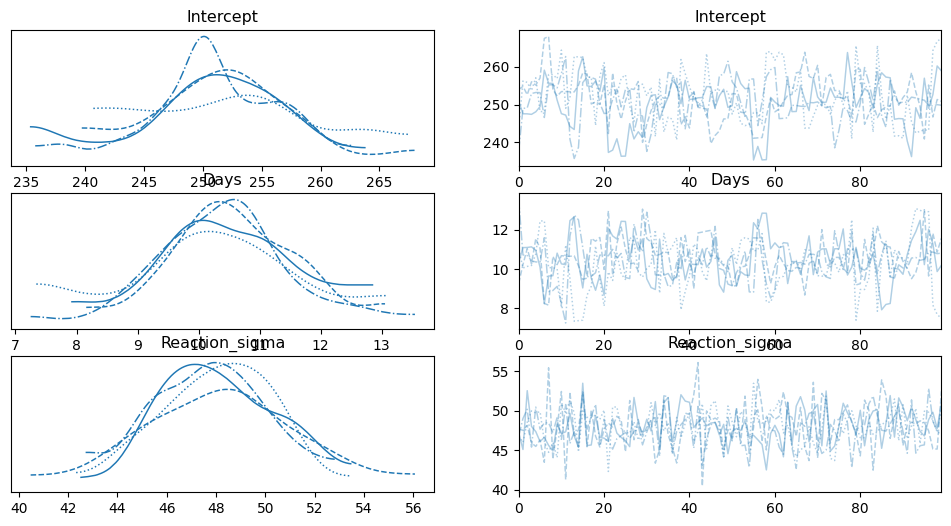

In [12]:
# Use ArviZ to plot the results
az.plot_trace(results)

## Framework Model

In [13]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 50 non-null     object 
 1   economics             50 non-null     float64
 2   environment           50 non-null     float64
 3   health                50 non-null     float64
 4   production            50 non-null     float64
 5   social                50 non-null     float64
 6   population            50 non-null     float64
 7   foodEnvironmentIndex  50 non-null     float64
 8   lifeExpectancy        50 non-null     float64
 9   foodInsecurity        50 non-null     float64
 10  happinessScore        50 non-null     float64
 11  wellbeingRank         50 non-null     float64
 12  communityEnvRank      50 non-null     float64
 13  workEnvRank           50 non-null     float64
 14  gdpCurrent            50 non-null     float64
 15  gdp_per_cap           50 

In [27]:
# fixed effect model, dropping relevant NAs
# just use a few variables for simple model
model = bmb.Model(
    'foodInsecurity ~ economics + environment',
    data=dat,
    dropna=True
)
model

       Formula: foodInsecurity ~ economics + environment
        Family: gaussian
          Link: mu = identity
  Observations: 50
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.10505999999999999, sigma: 0.32918031169683176)
            economics ~ Normal(mu: 0.0, sigma: 0.7786396935447593)
            environment ~ Normal(mu: 0.0, sigma: 0.6407467554859748)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.023082816119355976)

Sampling: [Intercept, economics, environment, foodInsecurity_sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'foodInsecurity_sigma'}>,
       <Axes: title={'center': 'economics'}>,
       <Axes: title={'center': 'environment'}>], dtype=object)

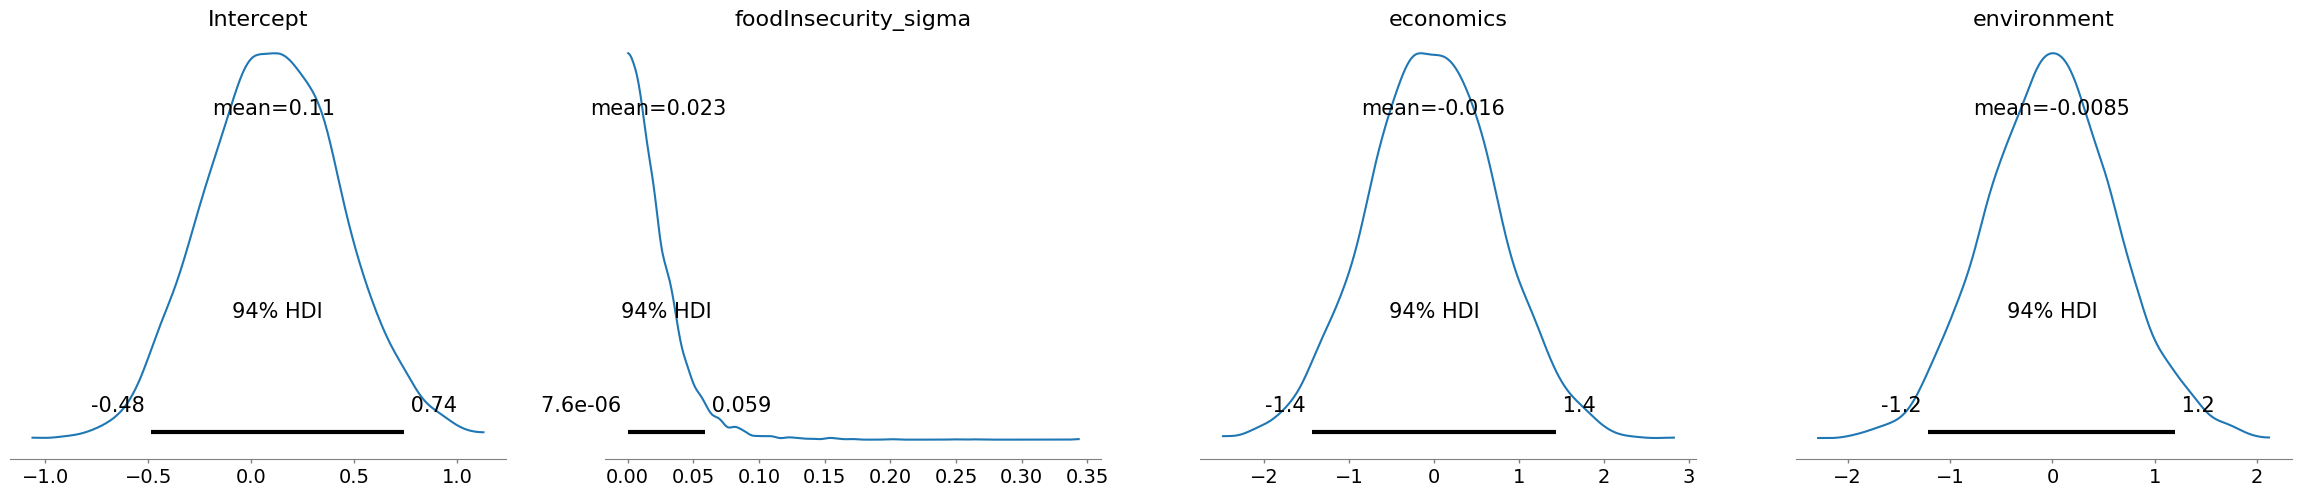

In [28]:
# Before examining model, check out priors
model.build()
model.plot_priors()

In [21]:
# Fit the model using 100 on each chain, just to make things go faster for testing
results = model.fit(draws=100, tune=100)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [foodInsecurity_sigma, Intercept, economics, environment]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
# examine model
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.131,0.018,0.094,0.162,0.001,0.001,297.0,182.0,1.00
economics,-0.090,0.042,-0.175,-0.011,0.003,0.002,265.0,237.0,1.01
environment,-0.005,0.040,-0.071,0.079,0.003,0.003,263.0,133.0,1.02
foodInsecurity_sigma,0.023,0.002,0.019,0.028,0.000,0.000,92.0,74.0,1.03


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'economics'}>,
        <Axes: title={'center': 'economics'}>],
       [<Axes: title={'center': 'environment'}>,
        <Axes: title={'center': 'environment'}>],
       [<Axes: title={'center': 'foodInsecurity_sigma'}>,
        <Axes: title={'center': 'foodInsecurity_sigma'}>]], dtype=object)

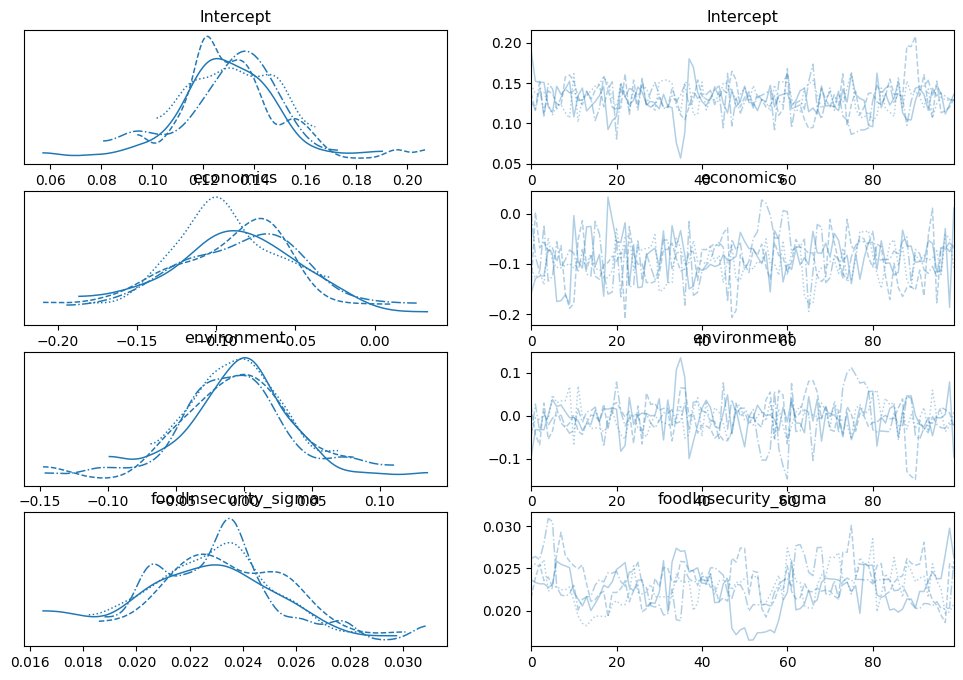

In [29]:
# trace plot
az.plot_trace(results)

### Add Priors

Same thing but with priors

In [42]:
# Create a normal prior, mean 0.5, sd 0.25
normal_prior = bmb.Prior("Normal", mu=0.5, sigma=0.25)

# Use normal prior for economics and environment
priors = {"economics": normal_prior, 'environment': normal_prior}

In [43]:
# fixed effect model, dropping relevant NAs
# just use a few variables for simple model
model = bmb.Model(
    'foodInsecurity ~ economics + environment',
    data=dat,
    dropna=True,
    priors=priors
)
model

       Formula: foodInsecurity ~ economics + environment
        Family: gaussian
          Link: mu = identity
  Observations: 50
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.10505999999999999, sigma: 0.05770704029838994)
            economics ~ Normal(mu: 0.5, sigma: 0.25)
            environment ~ Normal(mu: 0.5, sigma: 0.25)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.023082816119355976)

Sampling: [Intercept, economics, environment, foodInsecurity_sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'foodInsecurity_sigma'}>,
       <Axes: title={'center': 'economics'}>,
       <Axes: title={'center': 'environment'}>], dtype=object)

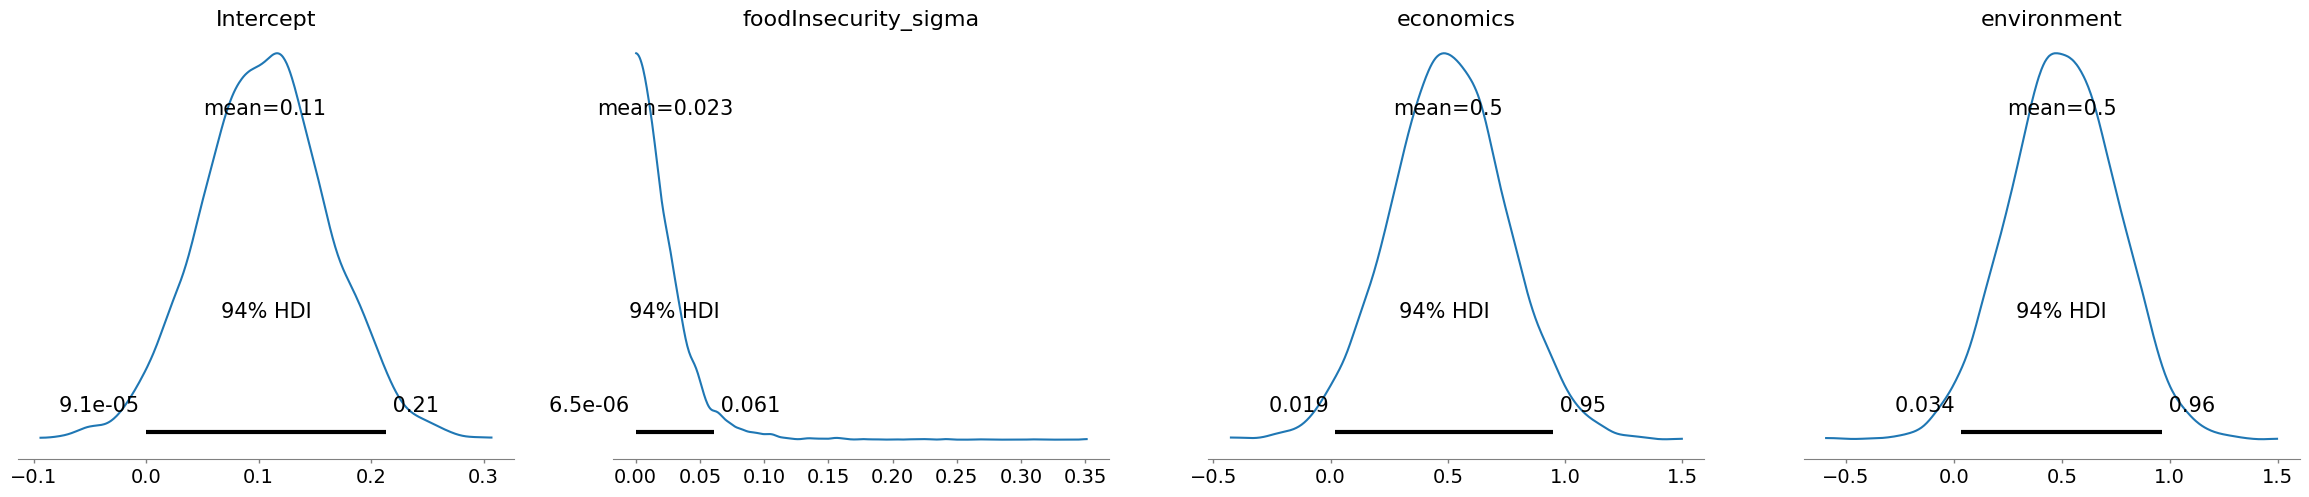

In [44]:
# Build model and check priors from model?
model.build()
model.plot_priors()

In [45]:
# Fit the model using 100 on each chain, just to make things go faster for testing
results = model.fit(draws=100, tune=100)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [foodInsecurity_sigma, Intercept, economics, environment]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [46]:
# Summary
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.124,0.016,0.095,0.153,0.001,0.001,320.0,246.0,1.00
economics,-0.076,0.045,-0.146,0.015,0.003,0.003,235.0,217.0,1.01
environment,0.005,0.036,-0.062,0.064,0.002,0.002,332.0,287.0,1.02
foodInsecurity_sigma,0.023,0.002,0.020,0.028,0.000,0.000,141.0,121.0,1.05


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'economics'}>,
        <Axes: title={'center': 'economics'}>],
       [<Axes: title={'center': 'environment'}>,
        <Axes: title={'center': 'environment'}>],
       [<Axes: title={'center': 'foodInsecurity_sigma'}>,
        <Axes: title={'center': 'foodInsecurity_sigma'}>]], dtype=object)

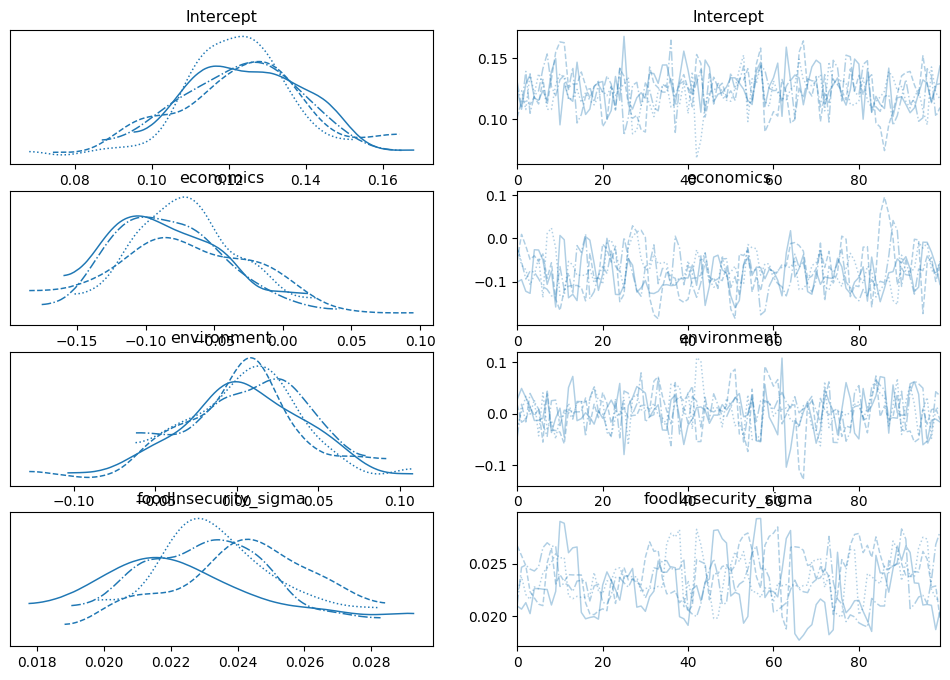

In [47]:
# trace plot
az.plot_trace(results)